## XGBoost algorithm for MNIST dataset classification

### package imports, data loading

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics

In [4]:
#solve kernel problems during XGBoost training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
#load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
print(type(x_train))
print(x_train.shape)
print(type(x_test))
print(x_test.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)
<class 'numpy.ndarray'>
(10000, 28, 28)


### Data exploration

- Plot several pictures with their respective labels

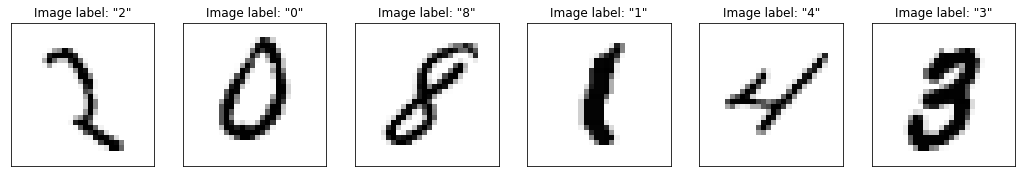

In [7]:
plt.figure(figsize=(18,5))
picture_indeces = [444,666,7777,7788,13987,33145]
for i in range(len(picture_indeces)):
    ax = plt.subplot(1,len(picture_indeces),i+1)
    image_index = picture_indeces[i]
    plt.imshow(x_train[image_index], cmap='Greys')
    #don't show ticks and labels
    plt.tick_params(axis='x',which='both',bottom=False, labelbottom=False)
    plt.tick_params(axis='y',which='both',left=False, labelleft=False)
    plt.title("Image label: \"{}\"".format(y_train[image_index]))

- Show histogram of labels

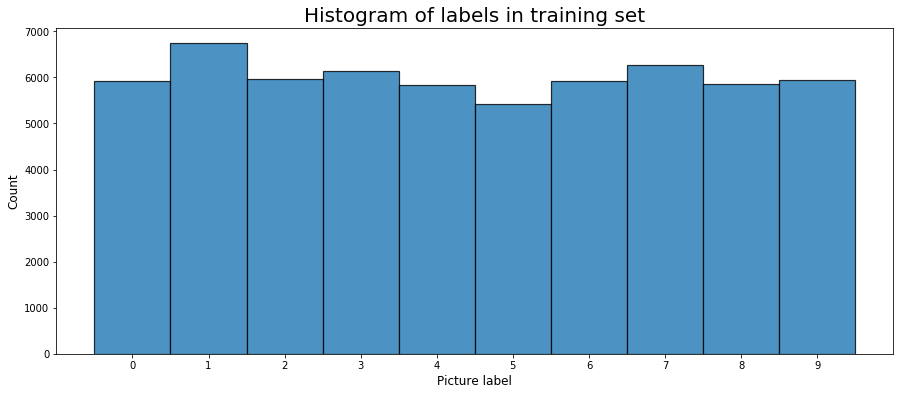

In [8]:
plt.figure(figsize=(15,6))
bins = np.arange(11) - 0.5 #to center xticks
plt.hist(y_train, edgecolor='black', linewidth=1.2, bins=bins, alpha=0.8)
plt.title("Histogram of labels in training set", fontsize=20)
plt.xlabel("Picture label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(0,10))
plt.show()

### XGBoost model training

1. Data preprocessing - flattening images to 1D arrays and rescaling grey shade values from [0,255] to [0,1]
2. XGBClassifier model training

In [9]:
x_train = (x_train / 255.0).reshape([60000, 28*28])
x_test = (x_test / 255.0).reshape([10000, 28*28])
print('x_train shape:', x_train.shape)
print('Number of images in x_train:', x_train.shape[0])
print('Number of images in x_test: ', x_test.shape[0])

# x_train = pd.DataFrame(x_train)
# x_test = pd.DataFrame(x_test)
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

x_train shape: (60000, 784)
Number of images in x_train: 60000
Number of images in x_test:  10000


In [13]:
from xgboost import XGBClassifier
import time
start = time.time()

print(type(x_train))
print(x_train.shape)
print(type(y_train))
print(y_train.shape)

model = XGBClassifier()
model.fit(x_train, y_train)

end = time.time()
print("Training duration: {:.2f} s".format(end - start))

<class 'numpy.ndarray'>
(60000, 784)
<class 'numpy.ndarray'>
(60000,)
Training duration: 1930.89 s


In [14]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.68%


Since a single training of XGBClassifier for MNIST training dataset takes 1930.89 s (~ 32 minutes), it is not a great candidate for model tuning.  
The training dataset needs to be reduced. There are several possibilities, how the dataset can be reduced (to 40 features):  
- select 40 random features (pixels)
- PCA - use first 40 components
- Isomap - use reduction to 40 dimensions
- t-SNE - use reduction to 40 dimensions

It should be noted that with default settings and no tuning, the accuracy was **93.68%**.

### XGBoost parameter description

#### General Parameters
Overall functionality of XGBoost.
1. booster [default=gbtree]
Select the type of model to run at each iteration. It has 2 options:
gbtree: tree-based models
gblinear: linear models
2. silent [default=0]:
Silent mode is activated is set to 1, i.e. no running messages will be printed.
It’s generally good to keep it 0 as the messages might help in understanding the model.
3. nthread [default to maximum number of threads available if not set]
This is used for parallel processing and number of cores in the system should be entered
If you wish to run on all cores, value should not be entered and algorithm will detect automatically
There are 2 more parameters which are set automatically by XGBoost and you need not worry about them. Lets move on to Booster parameters.

#### Booster Parameters
Consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

1. eta [default=0.3]  
Analogous to learning rate in GBM. 
Makes the model more robust by shrinking the weights on each step.  
Typical final values to be used: 0.01-0.2
2. min_child_weight [default=1]  
Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.  
Too high values can lead to under-fitting hence, it should be tuned using CV.
3. max_depth [default=6]  
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.  
Typical values: 3-10
4. max_leaf_nodes  
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.  
If this is defined, GBM will ignore max_depth.
5. gamma [default=0]  
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
6. max_delta_step [default=0]  
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
This is generally not used but you can explore further if you wish.
7. subsample [default=1]  
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.  
Typical values: 0.5-1
8. colsample_bytree [default=1]  
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.  
Typical values: 0.5-1
9. colsample_bylevel [default=1]  
Denotes the subsample ratio of columns for each split, in each level.
I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
10. lambda [default=1]  
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
11. alpha [default=0]  
L1 regularization term on weight (analogous to Lasso regression).
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
scale_pos_weight [default=1]    
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

#### Learning Task Parameters
These parameters are used to define the optimization objective the metric to be calculated at each step.

1. objective [default=reg:linear]  
This defines the loss function to be minimized. Mostly used values are:
binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
2. eval_metric [ default according to objective ]  
The metric to be used for validation data.
The default values are rmse for regression and error for classification.
Typical values are:
rmse – root mean square error
mae – mean absolute error
logloss – negative log-likelihood
error – Binary classification error rate (0.5 threshold)
merror – Multiclass classification error rate
mlogloss – Multiclass logloss
auc: Area under the curve
3. seed [default=0]  
The random number seed.  
Can be used for generating reproducible results and also for parameter tuning.  

XGBoost vs. Sklearn naming convention (xgboost –> sklearn): 
- eta –> learning_rate
- lambda –> reg_lambda
- alpha –> reg_alpha

### Dimensionality reduction

As the first step, MNIST dataset will be reduced to 2 dimension using three different techniques (PCA, Isomap, t-SNE) and results will be compared by plotting the reduced datasets.

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE

digit_colors = ["red","yellow","black","blue","plum","magenta","aqua","lime","orange","olive"]

In [11]:
import time
target_dimensions = 2
#pca
start = time.time()
pca = PCA(n_components=target_dimensions)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

end = time.time()
print("PCA duration: {:.2f} s".format(end - start))

PCA duration: 1.58 s


In [12]:
#isomap
start = time.time()
iso = Isomap(n_neighbors=3, n_components=target_dimensions)
iso.fit(x_train[0:30000,:])
x_train_iso = iso.transform(x_train)

end = time.time()
print("Isomap duration: {:.2f} s".format(end - start))

Isomap duration: 5366.15 s


In [27]:
#t-SNE
start = time.time()
t_sne = TSNE(n_components=target_dimensions)
x_train_tsne = t_sne.fit_transform(x_train)

end = time.time()
print("t-SNE duration: {:.2f} s".format(end - start))

t-SNE duration: 4492.04 s


In [ ]:
# x_test_pca = pca.transform(x_test)
# x_test_iso = iso.transform(x_test)
# x_test_tsne = t_sne.transform(x_test)

Text(0.5, 1.0, 'PCA')

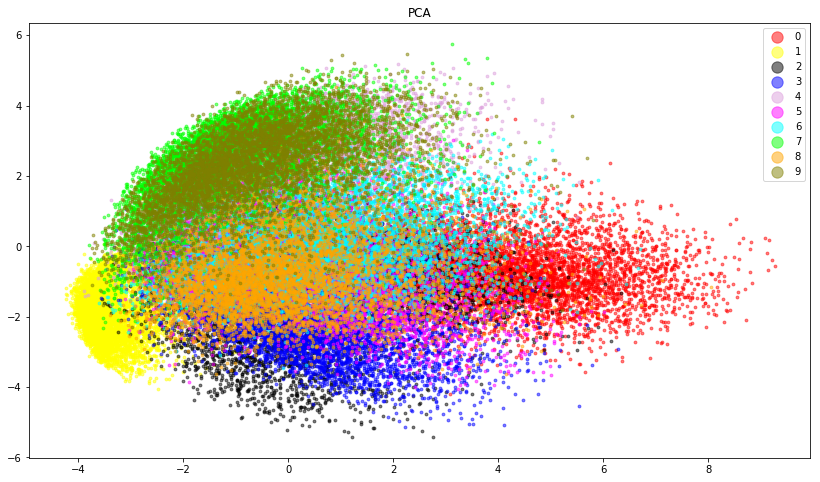

In [20]:
from matplotlib import colors
fig, ax = plt.subplots()
fig.set_size_inches(14,8)
for color in digit_colors:
    index = digit_colors.index(color)
    mask = y_train == index
    x = x_train_pca[mask,0]
    y = x_train_pca[mask,1]
    ax.scatter(x,y,c=color,alpha=0.5,s=8,label=index)

ax.legend(markerscale=4)
ax.set_title("PCA")

Text(0.5, 1.0, 'Isomap')

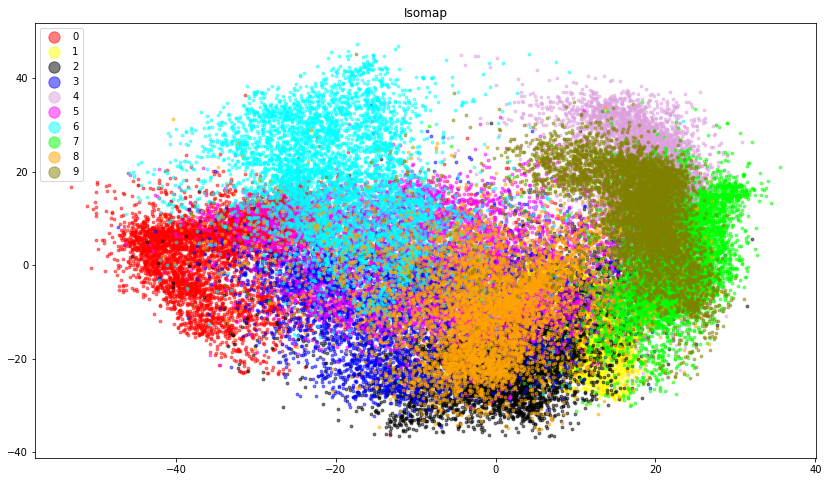

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(14,8)
for color in digit_colors:
    index = digit_colors.index(color)
    mask = y_train == index
    x = x_train_iso[mask,0]
    y = x_train_iso[mask,1]
    ax.scatter(x,y,c=color,alpha=0.5,s=8,label=index)

ax.legend(markerscale=4)
ax.set_title("Isomap")

Text(0.5, 1.0, 't-SNE')

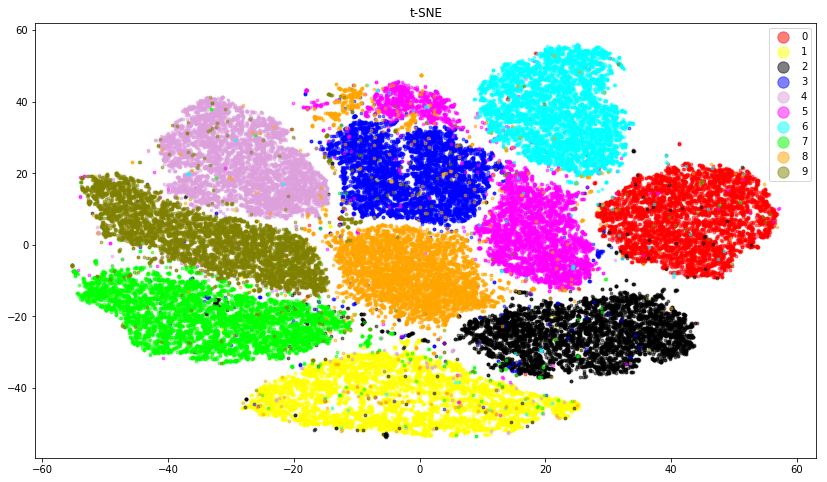

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(14,8)
for color in digit_colors:
    index = digit_colors.index(color)
    mask = y_train[0:len(x_train_tsne)] == index
    x = x_train_tsne[mask,0]
    y = x_train_tsne[mask,1]
    ax.scatter(x,y,c=color,alpha=0.5,s=8,label=index)

ax.legend(markerscale=4)
ax.set_title("t-SNE")

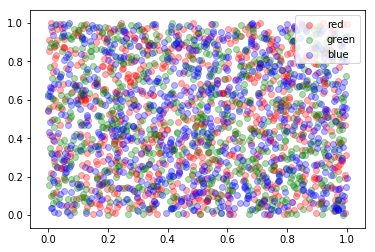

In [51]:
import matplotlib.pyplot as plt
from numpy.random import rand


fig, ax = plt.subplots()
for color in ['red', 'green', 'blue']:
    n = 750
    x, y = rand(2, n)
    ax.scatter(x, y, c=color, label=color,
               alpha=0.3)

ax.legend()

plt.show()

Text(0.5, 1.0, 'Isomap (30 000 samples)')

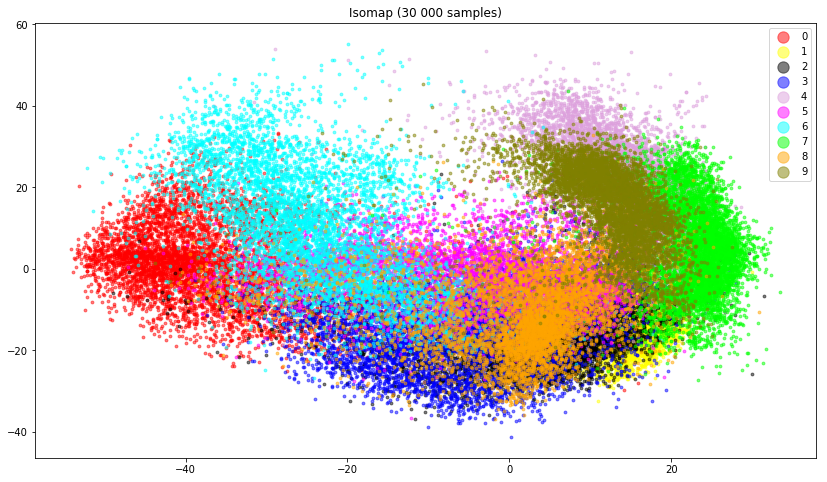

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(14,8)
for color in digit_colors:
    index = digit_colors.index(color)
    mask = y_train == index
    x = x_train_iso[mask,0]
    y = x_train_iso[mask,1]
    ax.scatter(x,y,c=color,alpha=0.5,s=8,label=index)

ax.legend(markerscale=4)
ax.set_title("Isomap (30 000 samples)")